In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Data Preparation

In [ ]:
# import and preview raw data
raw_data = pd.read_csv('ifood.csv')
raw_data.head()


,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


In [ ]:
# create a copy of raw_data and start cleaning
cleaned_data = raw_data.copy()

In [ ]:
# drop constant features
cleaned_data.drop(columns=['Z_CostContact', 'Z_Revenue'], inplace=True)

In [ ]:
# convert education features to a single ordinal feature

education_data = cleaned_data.filter([
  'education_Basic', 'education_2n Cycle', 'education_Graduation', 'education_Master',
  'education_PhD'
])

# convert categorical columns to a single ordinal variable for education
education_level = education_data.values @ np.array([1, 2, 3, 4, 5])

# replace education categories with new feature
cleaned_data['education_level'] = education_level
cleaned_data = cleaned_data.drop(columns = [
  'education_2n Cycle', 'education_Basic', 'education_Graduation', 'education_Master',
  'education_PhD'
])

In [ ]:
# drop redundant features while keeping AcceptedCmpOverall
cleaned_data = cleaned_data.drop(columns=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'])

# Data Exploration

In [ ]:
# function for graphing correlation matrices
def plot_correlation_heatmap(df, annot=False, title='Correlation Matrix'):
  corr_matrix = df.corr()
  # Create the heatmap
  plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
  sns.heatmap(corr_matrix, annot=annot, cmap='coolwarm', vmin=-1, vmax=1)
  plt.title(title)
  plt.show()

In [ ]:
# Split data into subgroups for easier visualization
sales_data = cleaned_data.filter(['Response', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'MntTotal', 'MntRegularProds','NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmpOverall'])
customer_data = cleaned_data.filter(['Response', 'Income', 'Kidhome', 'Teenhome', 'Recency','Complain', 'Age', 'Customer_Days', 'marital_Divorced', 'marital_Married',
       'marital_Single', 'marital_Together', 'marital_Widow', 'education_level'])

### Correlation Matrices

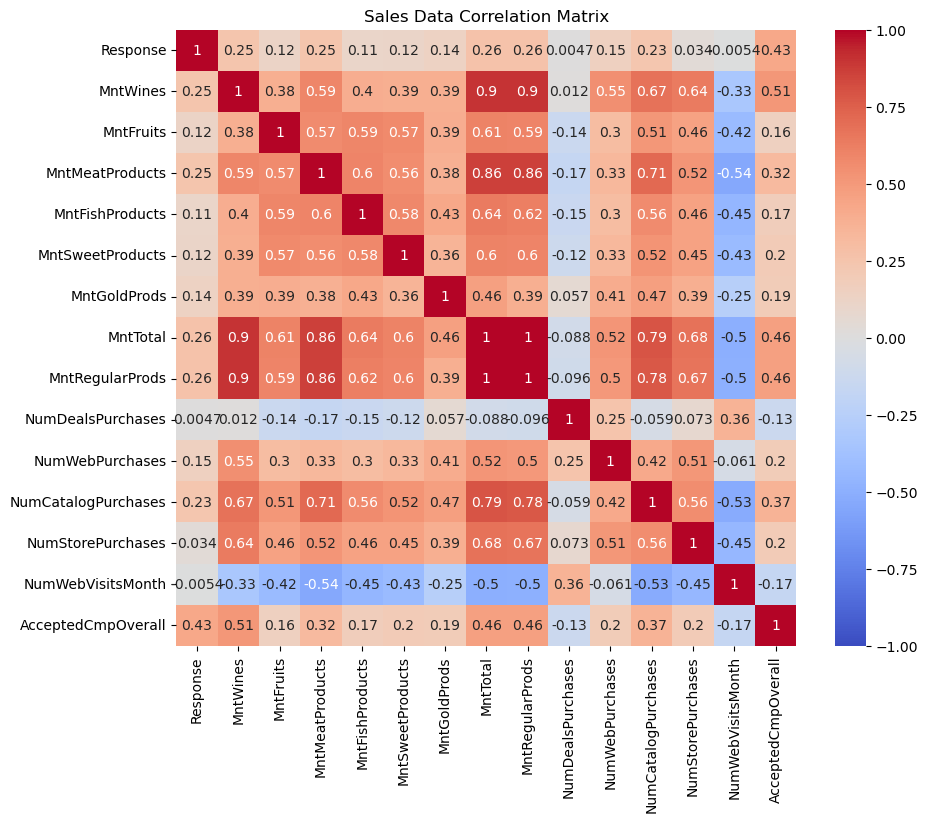

In [ ]:
plot_correlation_heatmap(sales_data, title='Sales Data Correlation Matrix')

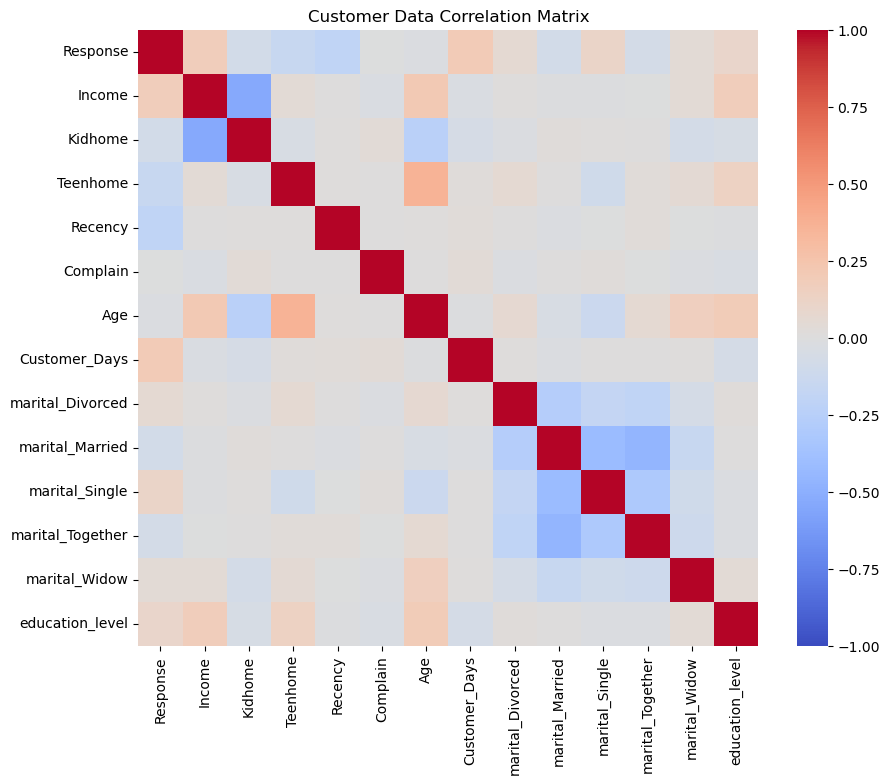

In [10]:
plot_correlation_heatmap(customer_data, title='Customer Data Correlation Matrix')

### Further Data Relationships Exploration

(0.0, 1.0)

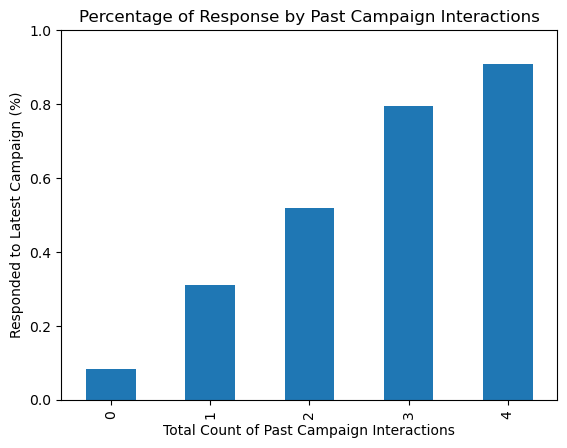

In [ ]:
ax = cleaned_data.groupby('AcceptedCmpOverall')['Response'].mean().plot.bar()
ax.set_title('Percentage of Response by Past Campaign Interactions')
ax.set_ylabel('Responded to Latest Campaign (%)')
ax.set_xlabel('Total Count of Past Campaign Interactions')
ax.set_ylim(bottom=0, top=1)

Text(0.5, 1.0, 'MntTotal by MntRegularProds')

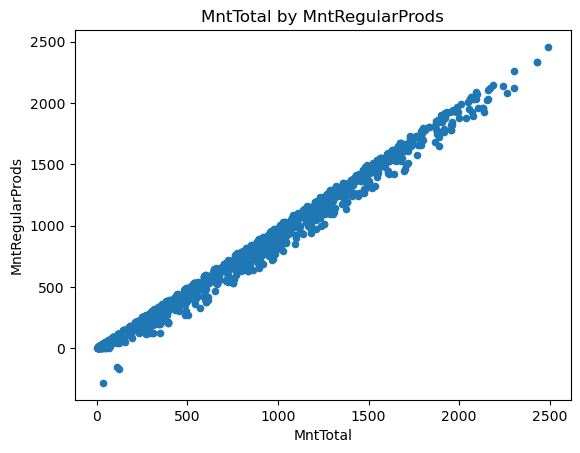

In [ ]:
ax = cleaned_data.plot.scatter(x='MntTotal', y='MntRegularProds')
ax.set_title('MntTotal by MntRegularProds')

In [ ]:
# drop redundant feature
cleaned_data = cleaned_data.drop(colunns=['MntRegularProds'])

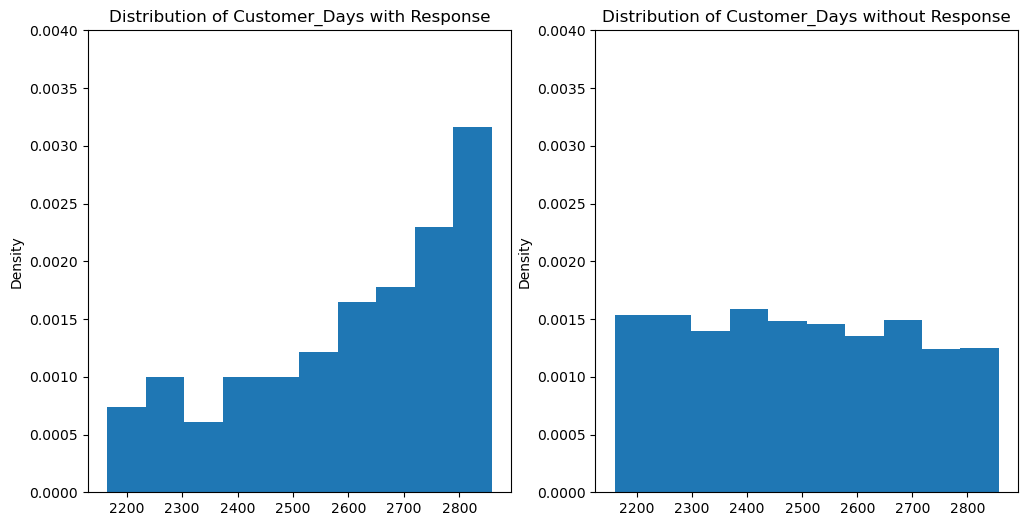

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

cleaned_data[cleaned_data['Response'] == 1]['Customer_Days'].plot.hist(ax=ax1, density=True)
ax1.set_title('Distribution of Customer_Days with Response')
ax1.set_ylim(bottom=0, top=0.004)
ax1.set_ylabel('Density')

cleaned_data[cleaned_data['Response'] == 0]['Customer_Days'].plot.hist(ax=ax2, density=True)
ax2.set_title('Distribution of Customer_Days without Response')
ax2.set_ylim(bottom=0, top=0.004)
ax2.set_ylabel('Density');

# Model Building

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into train and test splits
train, test = train_test_split(cleaned_data, test_size=0.2, random_state=42)

train_X = train.drop(columns=['Response'])
train_y = train['Response']

test_X = test.drop(columns=['Response'])
test_y = test['Response']

In [14]:
def tree_classifier_level(i, X_train, y_train, X_test, y_test):
    clf = DecisionTreeClassifier(max_depth=i, random_state=42)
    clf.fit(X_train, y_train)

    accuracy = clf.score(X_test, y_test)
    
    return clf.score(X_train, y_train), clf.score(X_test, y_test), accuracy

# Define the function to find the best depth for the decision tree
def find_best_depth(n, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    accuracy_list = []
    total_score = {
        "Depth": range(1, n + 1)
    }
    total_score = pd.DataFrame(total_score)
    
    for i in range(1, n + 1):
        train_score, test_score, accuracy = tree_classifier_level(i, X_train, y_train, X_test, y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)
        accuracy_list.append(accuracy)
        total_score.loc[total_score["Depth"] == i, "Total Score"] = abs(train_score - test_score)
    
    return total_score.loc[total_score["Total Score"].idxmin()]["Depth"], train_scores, test_scores, accuracy_list

### Small Tree Model

In [ ]:
# Construct a tree model with only a few selected features from the dataset

subset_features = ['MntTotal', 'AcceptedCmpOverall', 'Customer_Days', 'Income']

small_train_X = train_X[subset_features]
small_test_X = test_X[subset_features]

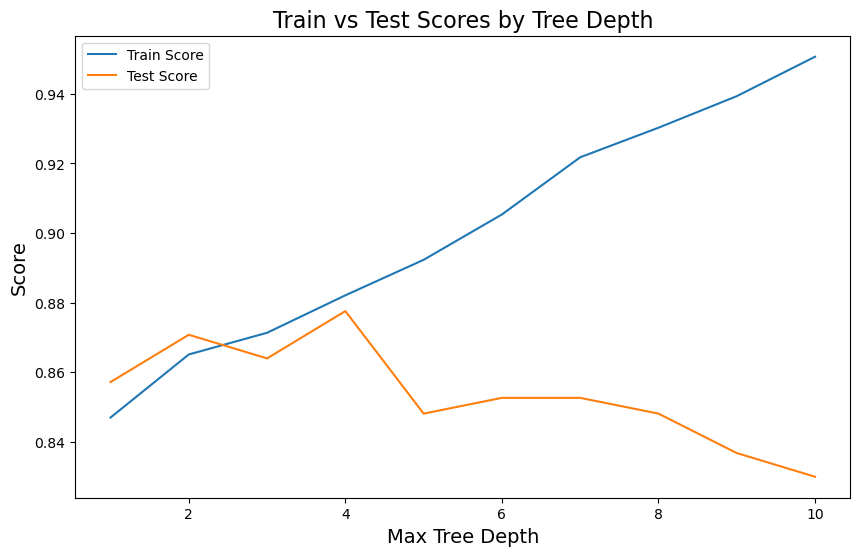

In [ ]:
# Find the best depth and visualize results
finc_res = find_best_depth(10, small_train_X, train_y, small_test_X, test_y)
train_scores, test_scores, accuracy_list = finc_res[1], finc_res[2], finc_res[3]

# Visualization of train and test scores vs tree depth
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(train_scores) + 1), y=train_scores, label='Train Score')
sns.lineplot(x=range(1, len(train_scores) + 1), y=test_scores, label='Test Score')
plt.xlabel('Max Tree Depth', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Train vs Test Scores by Tree Depth', fontsize=16)
plt.legend();

In [16]:
small_tree = DecisionTreeClassifier(max_depth=4, random_state=42)
small_tree.fit(small_train_X, train_y)
small_tree.score(small_test_X, test_y)

0.8775510204081632

### Large Tree Model

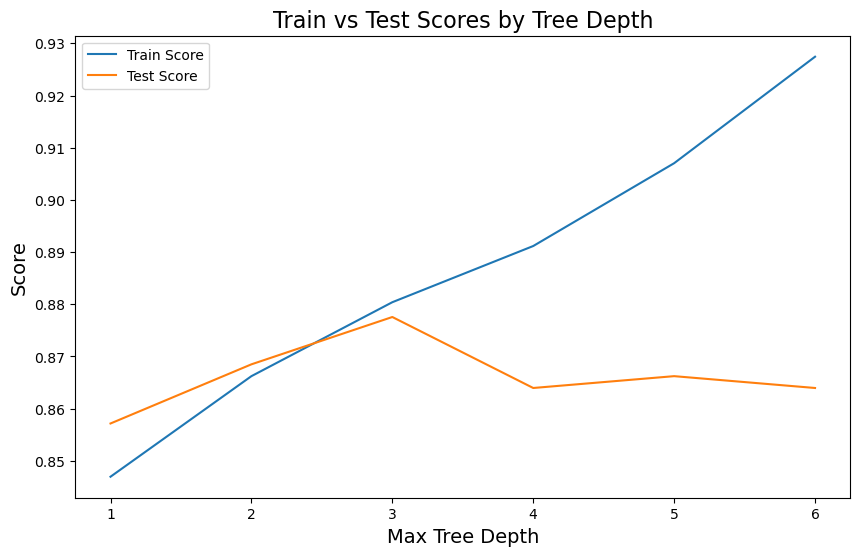

In [ ]:
# Use the entire feature set to build a model

# Find the best depth and visualize results
finc_res = find_best_depth(6, train_X, train_y, test_X, test_y)
train_scores, test_scores, accuracy_list = finc_res[1], finc_res[2], finc_res[3]

# Visualization of train and test scores vs tree depth
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(train_scores) + 1), y=train_scores, label='Train Score')
sns.lineplot(x=range(1, len(train_scores) + 1), y=test_scores, label='Test Score')
plt.xlabel('Max Tree Depth', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Train vs Test Scores by Tree Depth', fontsize=16)
plt.legend();

In [18]:
large_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
large_tree.fit(train_X, train_y)
large_tree.score(test_X, test_y)

0.8775510204081632

In [27]:
# Scores are exactly the same!
print(f'Small Tree Accuracy: {small_tree.score(small_test_X, test_y)}')
print(f'Large Tree Accuracy: {large_tree.score(test_X, test_y)}')

Small Tree Accuracy: 0.8775510204081632
Large Tree Accuracy: 0.8775510204081632


### Visualizing Trees With plot_tree()

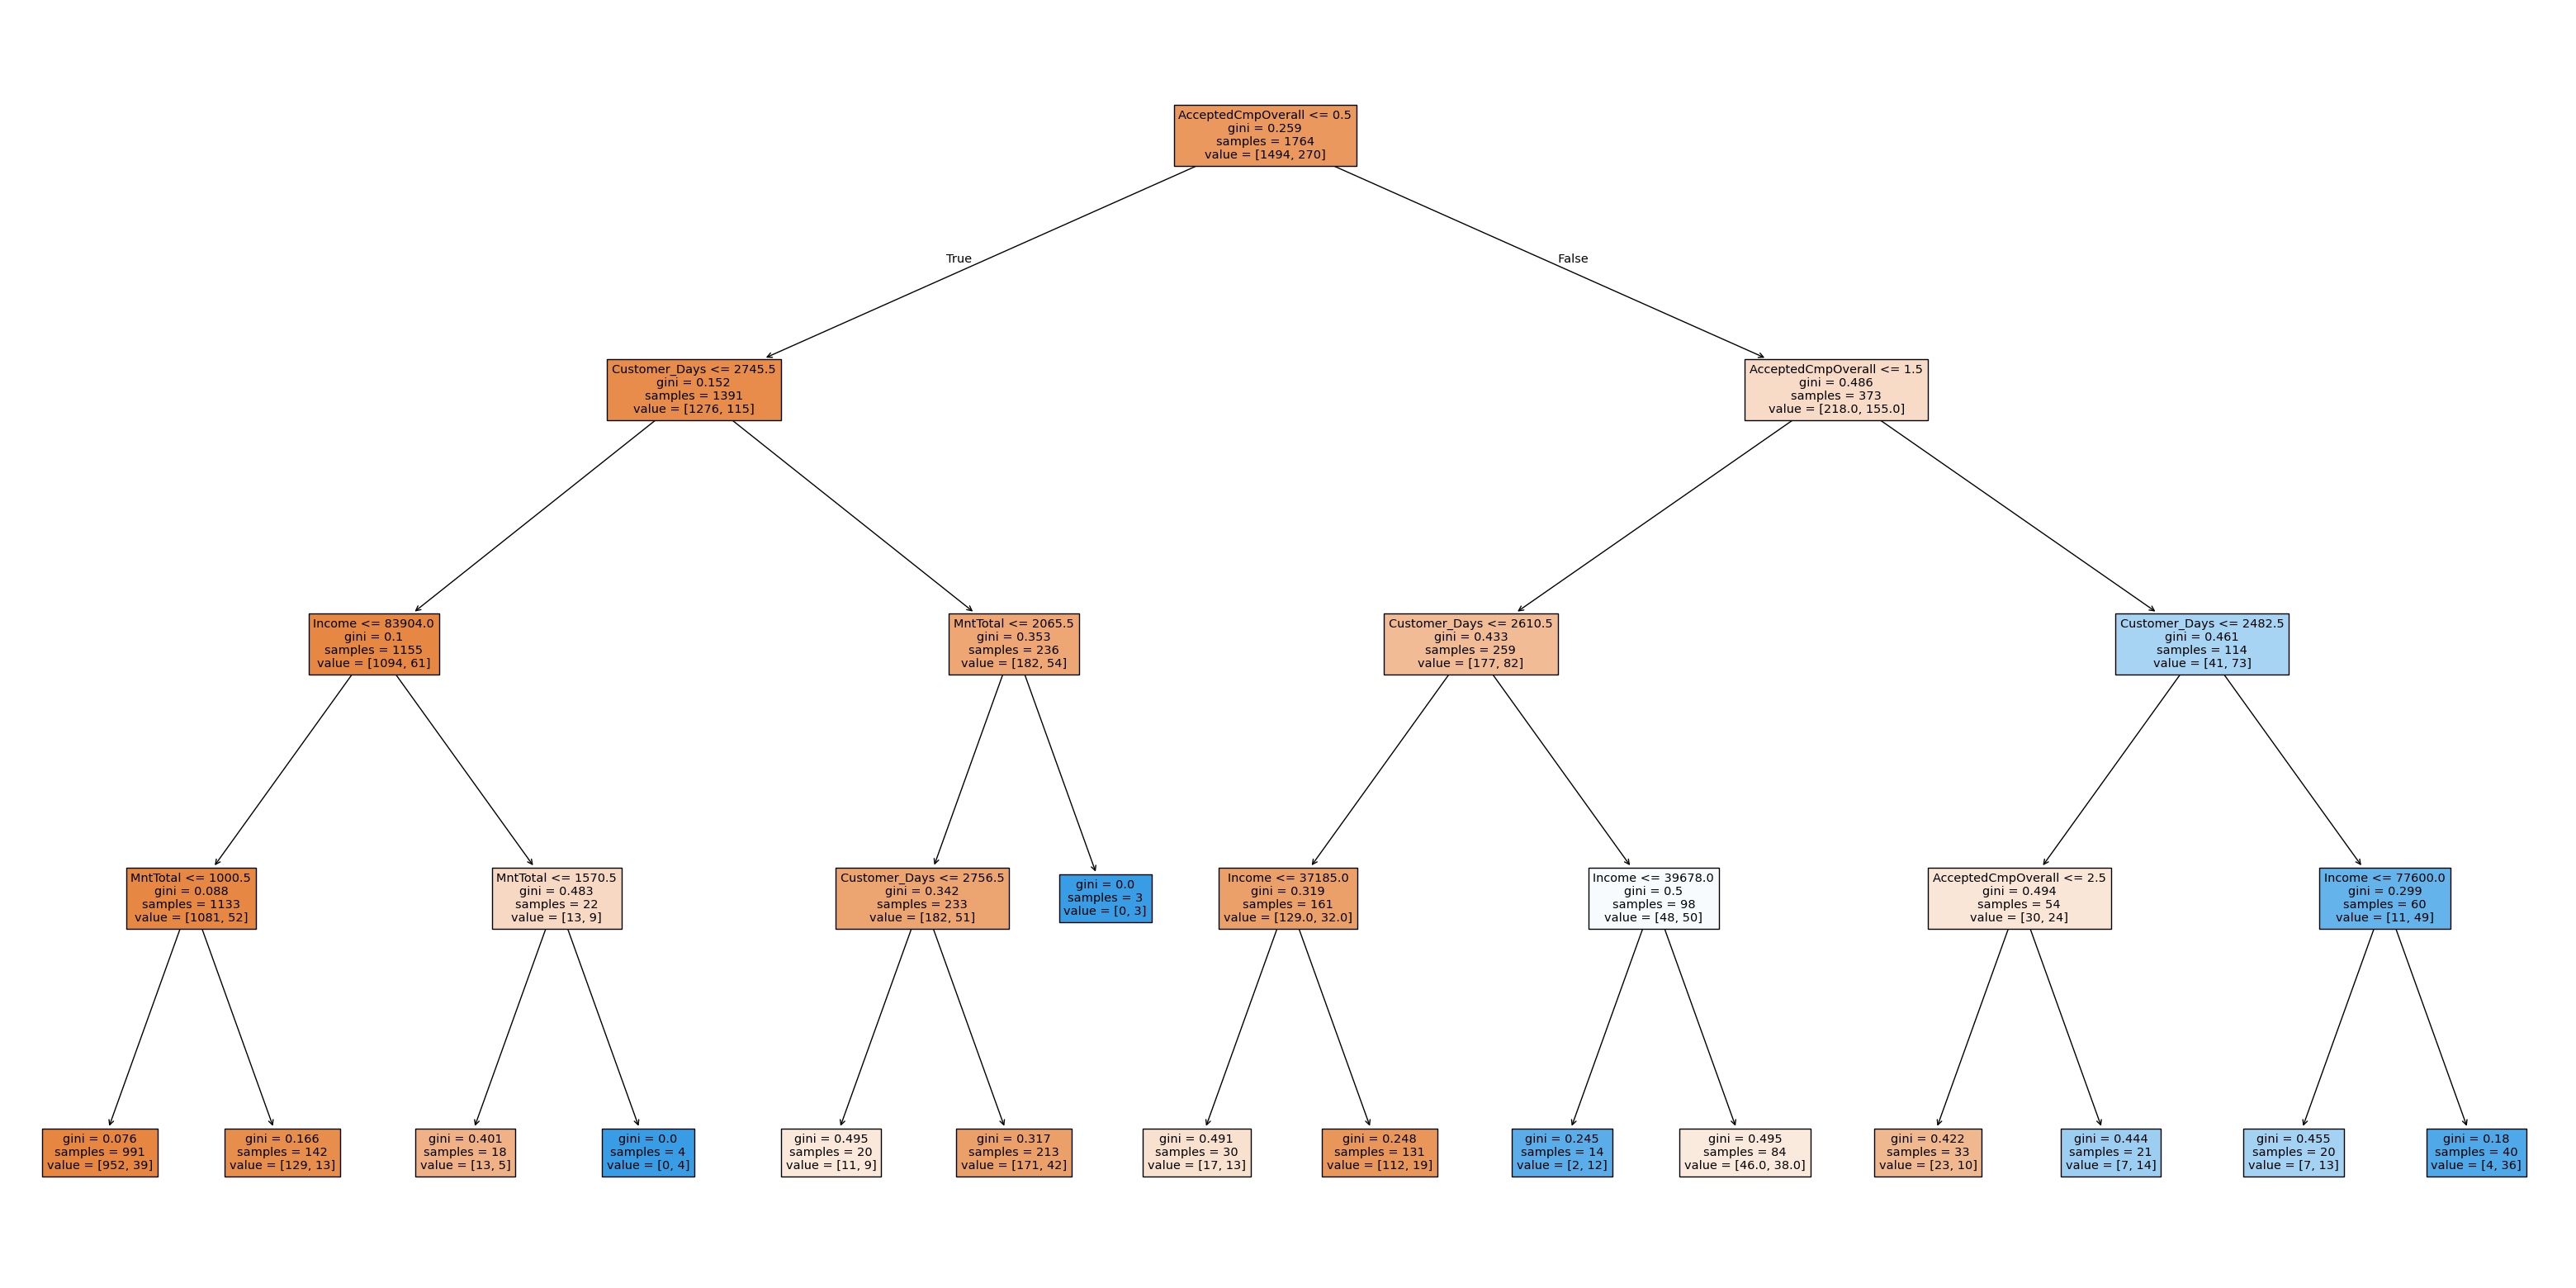

In [ ]:
from sklearn.tree import plot_tree

# Visualize small tree
plt.figure(figsize=(40, 20))
plot_tree(small_tree, filled=True, feature_names=list(small_train_X.columns))
plt.show()

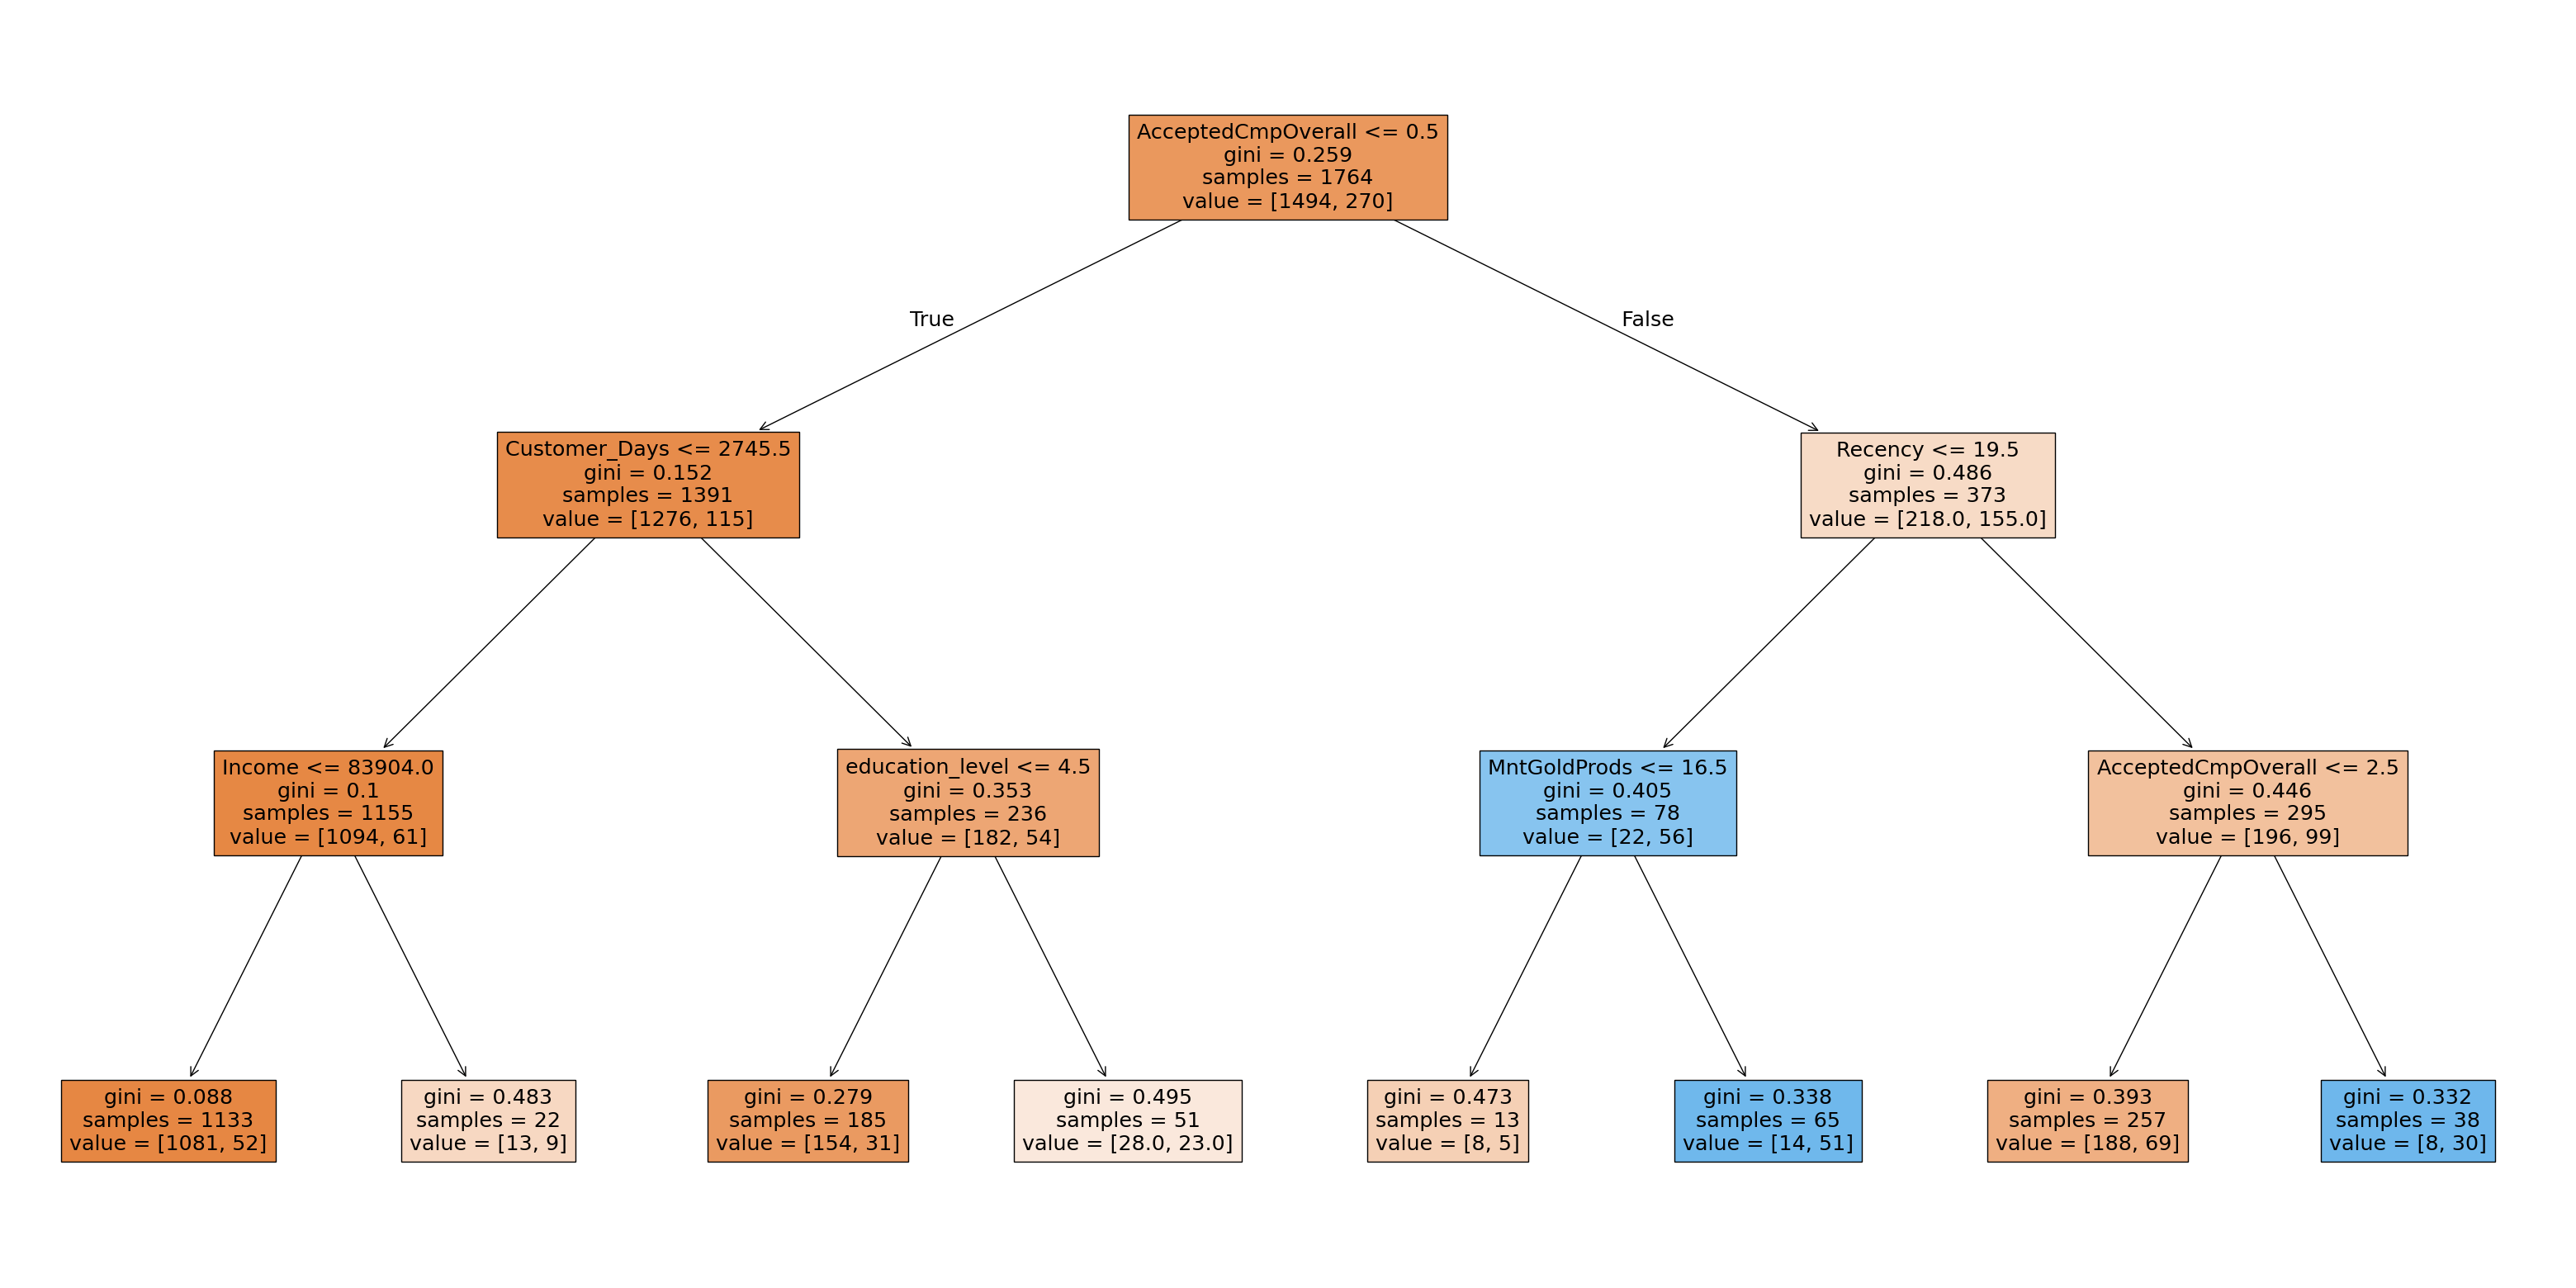

In [ ]:
# Visualize large tree
plt.figure(figsize=(40, 20))
plot_tree(large_tree, filled=True, feature_names=list(train_X.columns))
plt.show()